In [1]:
using Distributions
using HypothesisTests
using Random
Random.seed!(4649373)
using QuadGK
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, size=(400, 250), titlefontsize=10, tickfontsize=6, guidefontsize=9)

x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
function findpositive(f, a, b; maxsplit = 30)
    @assert f(a) < 0
    @assert f(b) < 0
    c = (a + b)/2
    f(c) > 0 && return c
    w = b - a
    for k in 2:maxsplit
        for d in range(w/2^(k+1), w/2-w/2^(k+1), step=w/2^k)
            x = c + d
            f(x) > 0 && return x 
            x = c - d
            f(x) > 0 && return x 
        end
    end
    error("k > maxplit = $maxsplit")
end

f(x) = abs(x) < 1e-4 ? 1.0 : -1.0

@time findpositive(f, -100abs(randn()), 20abs(randn()))

  0.000718 seconds


4.95082401883451e-5

In [4]:
"""
    prob_x_le_y(distx::UnivariateDistribution, disty::UnivariateDistribution;
        a = 0.0)

この函数は, 連続分布 `distx`, `disty` と実数 `a` について, 
`distx` と `disty` に従って生成される乱数をそれぞれ X, Y と書くとき, 
X ≤ Y + a が成立する確率を返す.
"""
function prob_x_le_y(distx::UnivariateDistribution, disty::UnivariateDistribution,
        a = 0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

"""
    tieshift(distx::UnivariateDistribution, disty::UnivariateDistribution;
        p = 0.5)

この函数は, 連続分布 `distx`, `disty` と実数 `p` について, 
`distx` と `disty` に従って生成される乱数をそれぞれ X, Y と書くとき, 
X ≤ Y + a が成立する確率が `p` に等しくなるような実数 a を返す.
"""
function tieshift(distx::UnivariateDistribution, disty::UnivariateDistribution;
        p=0.5)
    find_zero(a -> prob_x_le_y(distx, disty, a) - p, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [5]:
"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    phat_brunner_munzel(X, Y)

まず以下のようにおく:

```math
\begin{aligned}
&
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j]
\end{aligned}
```

この函数は次の $\hat{p}$ を返す:

```math
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j).
```
"""
phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

@doc raw"""
    statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^x - \bar{H}^y + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
```
"""
function statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        Hx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        Hy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(Hy) - mean(Hx) + n)/(m + n)
    sx2, sy2 = var(Hx)/n^2, var(Hy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
function pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, Hx, Hy; p).pvalue
end

"""
    tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)

この函数は `phat_brunner_munzel(X, Y .+ a)` の値が `p` に等しくなる `a` を返す.
"""
function tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (shiftmin, shiftmax))
end

@doc raw"""
    brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )

この函数はBrunner-Munzel検定を実行する. 詳細は以下の通り.

この函数は `phat`, `sehat`, `tvalue`, `df`, `p`, `pvalue`, `α` および\
以下達の named tuple を返す.

```math
\begin{aligned}
&
\mathrm{confint\_p} = (\text{$p$ の信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{confint\_shift} = (\text{2つの集団が互角になるようなシフトの信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{pvalue\_shift} = ($\mathrm{confint\_shift}$ の計算で使われたP値函数),
\\ &
\mathrm{shifthat} = (\text{2つの集団が互角になるようなシフトの点推定値}).
\end{aligned}
```

さらに, $\mathrm{shiftmin}$, $\mathrm{shiftmax}$ はデータから推定されるシフトの下限と上限.

"""
function brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, Hx, Hy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_shift(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, Hx, Hy; p)
    end
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    shifthat = tieshift(X, Y; p)
    confint_shift = [
        find_zero(a -> pvalue_shift(a) - α, (shiftmin, shifthat))
        find_zero(a -> pvalue_shift(a) - α, (shifthat, shiftmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax)
end

function show_plot_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, 
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax) =
        brunner_munzel(X, Y, Hx, Hy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
            confint_shift, shifthat))
    println()
    @show median(X) median(Y)
    plot(pvalue_shift, shiftmin, shiftmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of shift")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)

end

show_plot_brunner_munzel (generic function with 4 methods)

In [6]:
pval_mann_whitney_u(X, Y, a = 0.0) = pvalue(MannWhitneyUTest(X, Y .+ a))
pval_brunner_munzel(X, Y, a = 0.0) = pvalue_brunner_munzel(X, Y .+ a)
pval_welch_t(X, Y, a) = pvalue_welch(X, Y; Δμ = a)

function plot_pvals(X, Y; link=identity, kwargs...)
    f(a) = link(pval_mann_whitney_u(X, Y, a))
    g(a) = link(pval_brunner_munzel(X, Y, a))
    h(a) = link(pval_welch_t(X, Y, a))
    #ci_w = confint_welch(X, Y; α=0.001)
    #ci_bm = brunner_munzel(X, Y; α=0.001).confint_shift
    #amin, amax = min(ci_w[begin], ci_bm[begin]), max(ci_w[end], ci_bm[end])
    amin, amax = brunner_munzel(X, Y; α=0.005).confint_shift
    plot()
    plot!(f, amin, amax; label="WMW")
    plot!(g; label="BM", ls=:dash)
    plot!(h; label="Welch", ls=:dashdotdot)
    plot!(yscale=:log10, legend=:topleft)
    ytick = Any[0.005, 0.01, 0.05, 0.1, 0.5, 1]
    plot!(ytick=(float.(ytick), string.(ytick)), ylim=extrema(ytick))
    plot!(; kwargs...)
end

function iterplot_pvals(distx, disty, m, n; seed=nothing, kwargs...)
    isnothing(seed) || Random.seed!(seed)
    @show distx, m
    @show disty, n
    @show std(distx)/std(disty)
    @show mean(distx) - mean(disty)
    @show median(distx) - median(disty)
    @show tieshift(distx, disty)
    PP = []
    for _ in 1:15
        X, Y = rand(distx, m), rand(disty, n)
        P = plot_pvals(X, Y; kwargs...)
        push!(PP, P)
    end
    plot(PP...; size=(900, 900), layout=(5, 3))
    plot!(legendfontsize=7)
end

iterplot_pvals (generic function with 1 method)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=1.0), 20)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


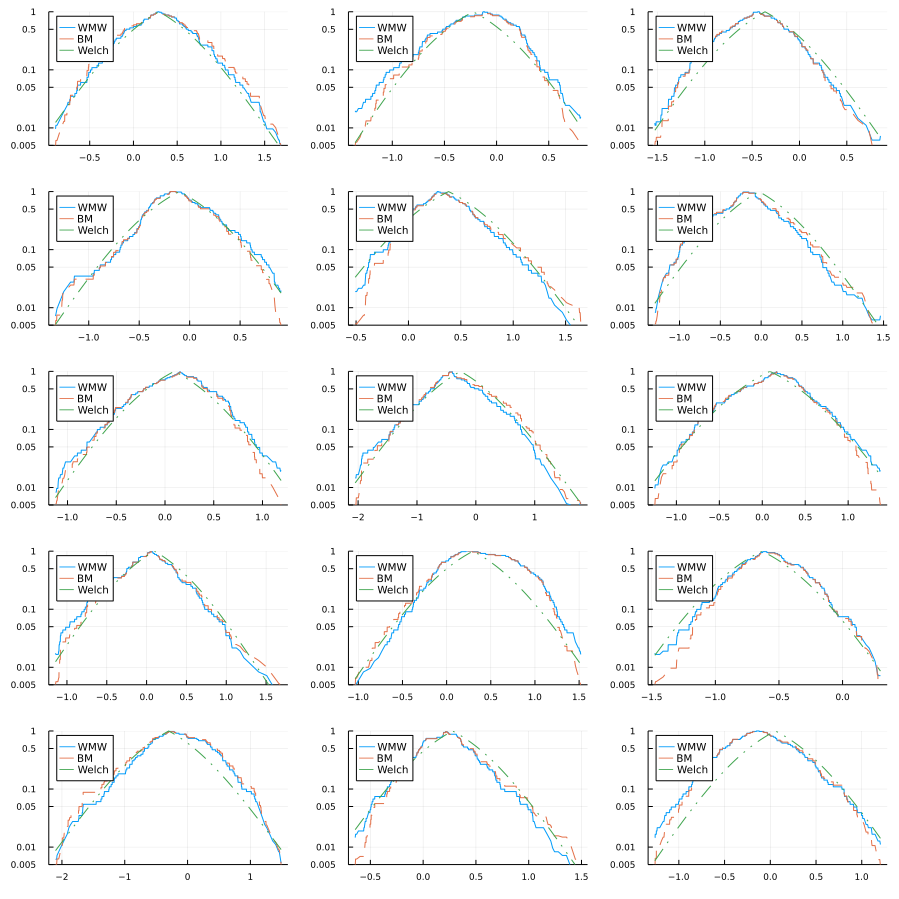

In [7]:
iterplot_pvals(Normal(), Normal(), 10, 20; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (Normal{Float64}(μ=0.0, σ=1.0), 15)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


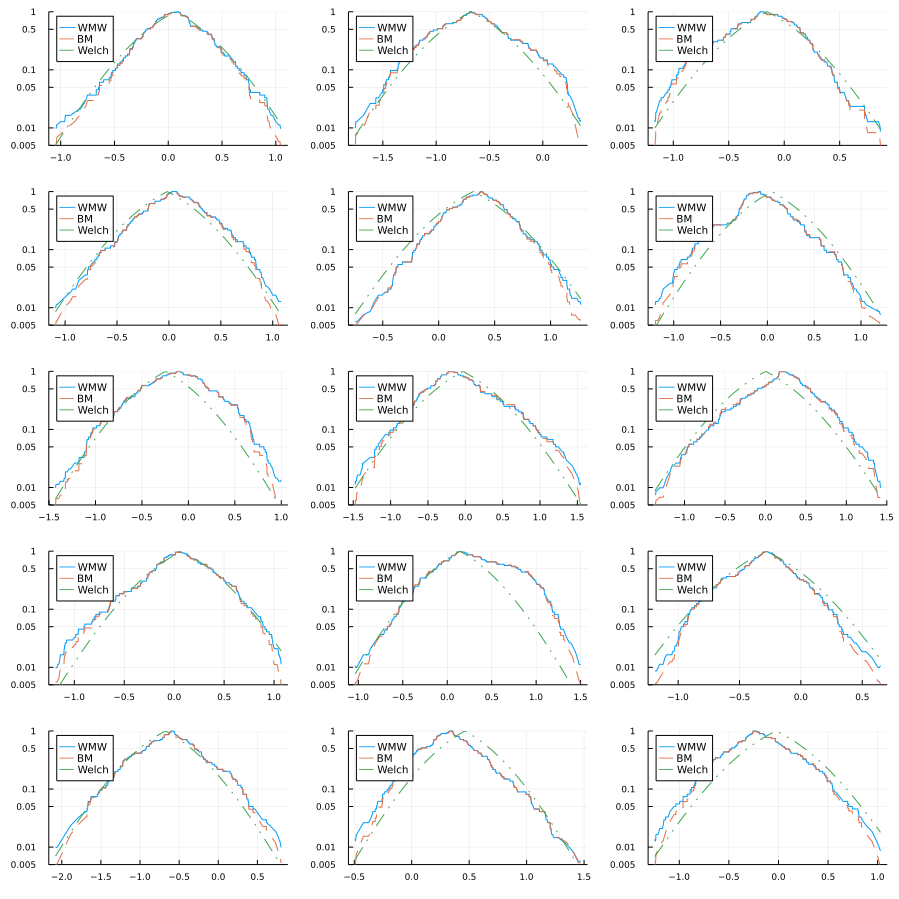

In [8]:
iterplot_pvals(Normal(), Normal(), 15, 15; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (Normal{Float64}(μ=0.0, σ=1.0), 10)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


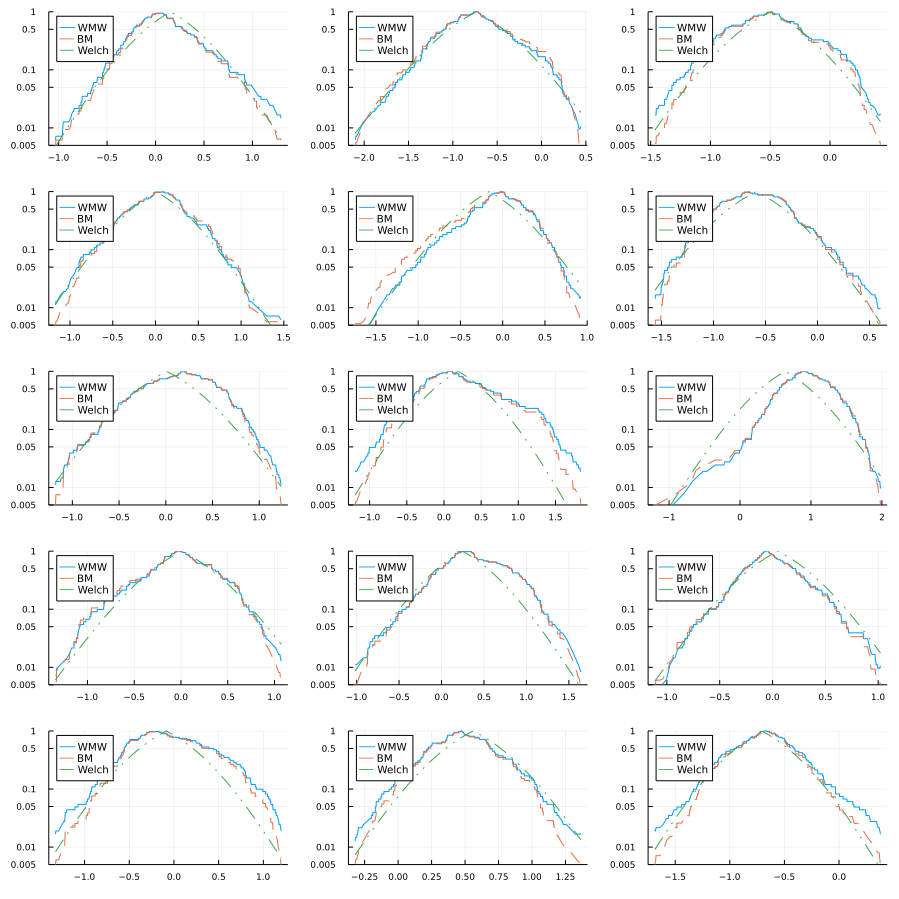

In [9]:
iterplot_pvals(Normal(), Normal(), 20, 10; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (Normal{Float64}(μ=0.0, σ=1.0), 100)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


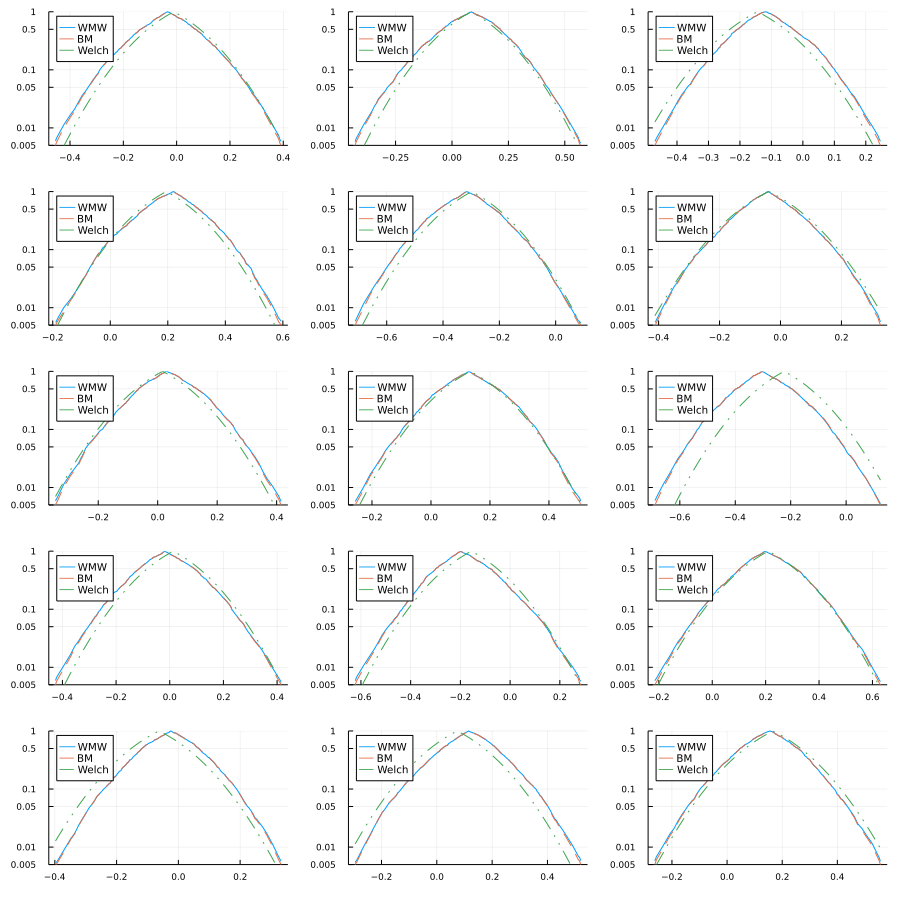

In [10]:
iterplot_pvals(Normal(), Normal(), 100, 100; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=4.0), 20)
std(distx) / std(disty) = 0.25
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = -2.7194016340191065e-13


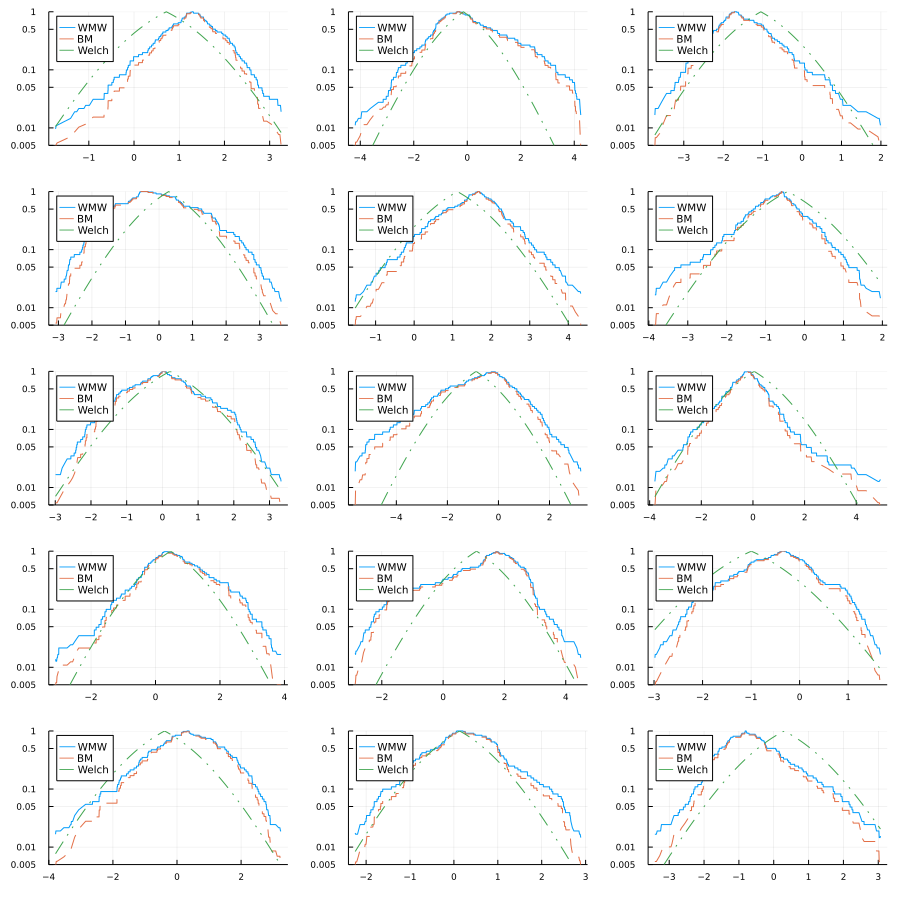

In [11]:
iterplot_pvals(Normal(0, 1), Normal(0, 4), 10, 20; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (Normal{Float64}(μ=0.0, σ=4.0), 15)
std(distx) / std(disty) = 0.25
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = -2.7194016340191065e-13


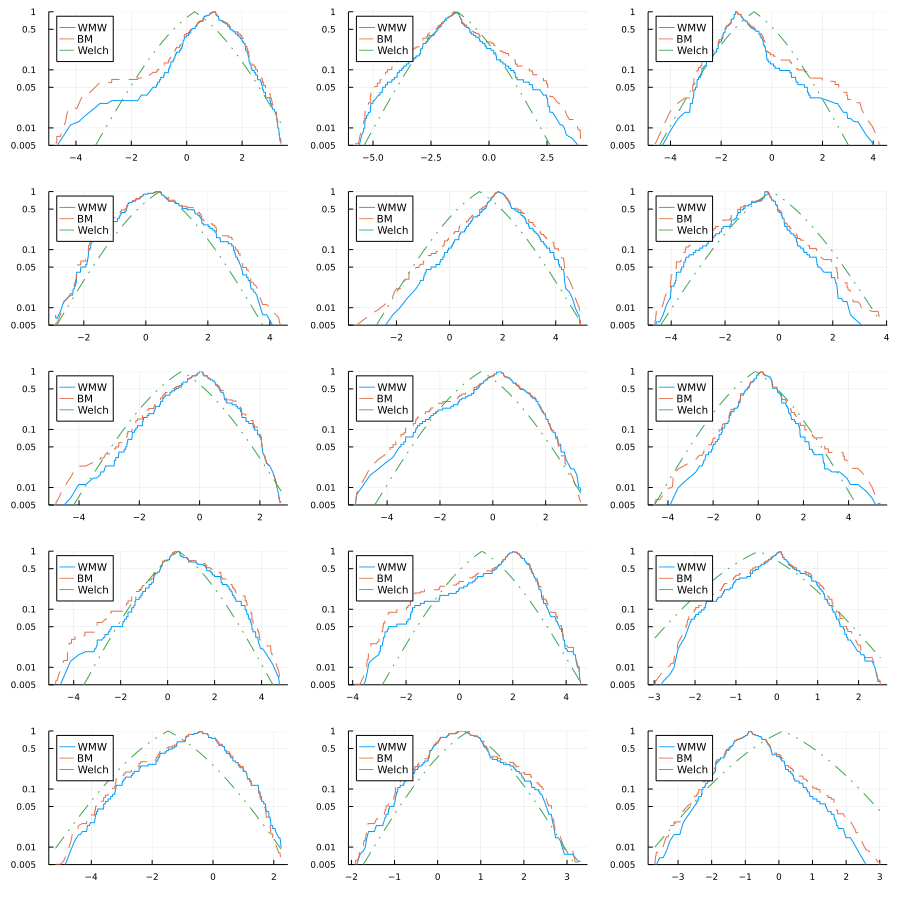

In [12]:
iterplot_pvals(Normal(0, 1), Normal(0, 4), 15, 15; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (Normal{Float64}(μ=0.0, σ=4.0), 10)
std(distx) / std(disty) = 0.25
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = -2.7194016340191065e-13


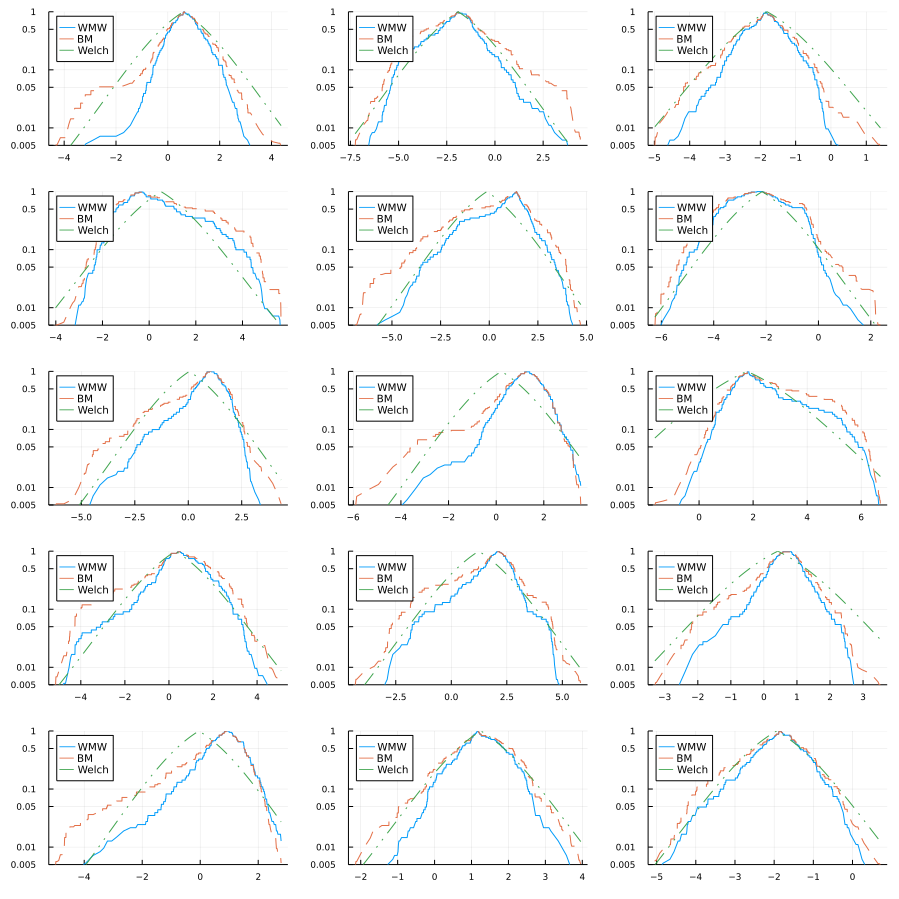

In [13]:
iterplot_pvals(Normal(0, 1), Normal(0, 4), 20, 10; seed=4649373)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (Normal{Float64}(μ=0.0, σ=4.0), 100)
std(distx) / std(disty) = 0.25
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = -2.7194016340191065e-13


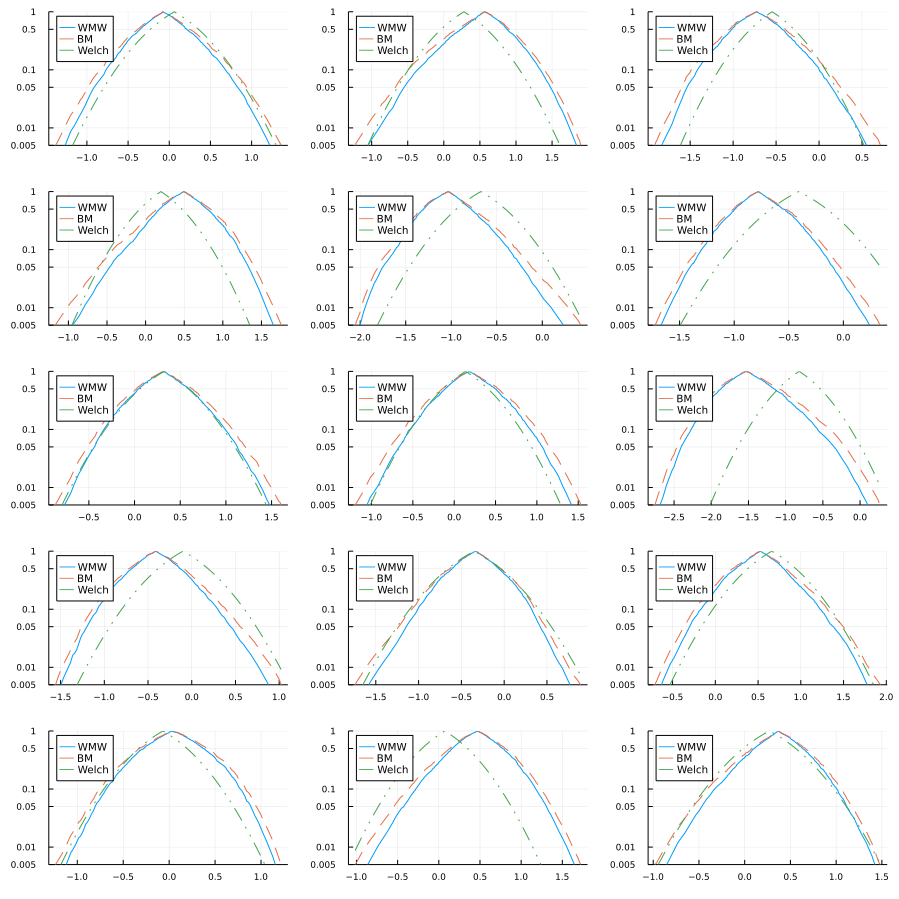

In [14]:
iterplot_pvals(Normal(0, 1), Normal(0, 4), 100, 100; seed=4649373)

(distx, m) = (Uniform{Float64}(a=0.0, b=2.0), 10)
(disty, n) = (Exponential{Float64}(θ=0.5773502691896257), 20)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.42264973081037427
median(distx) - median(disty) = 0.5998112887156855
tieshift(distx, disty) = 0.46294318113014316


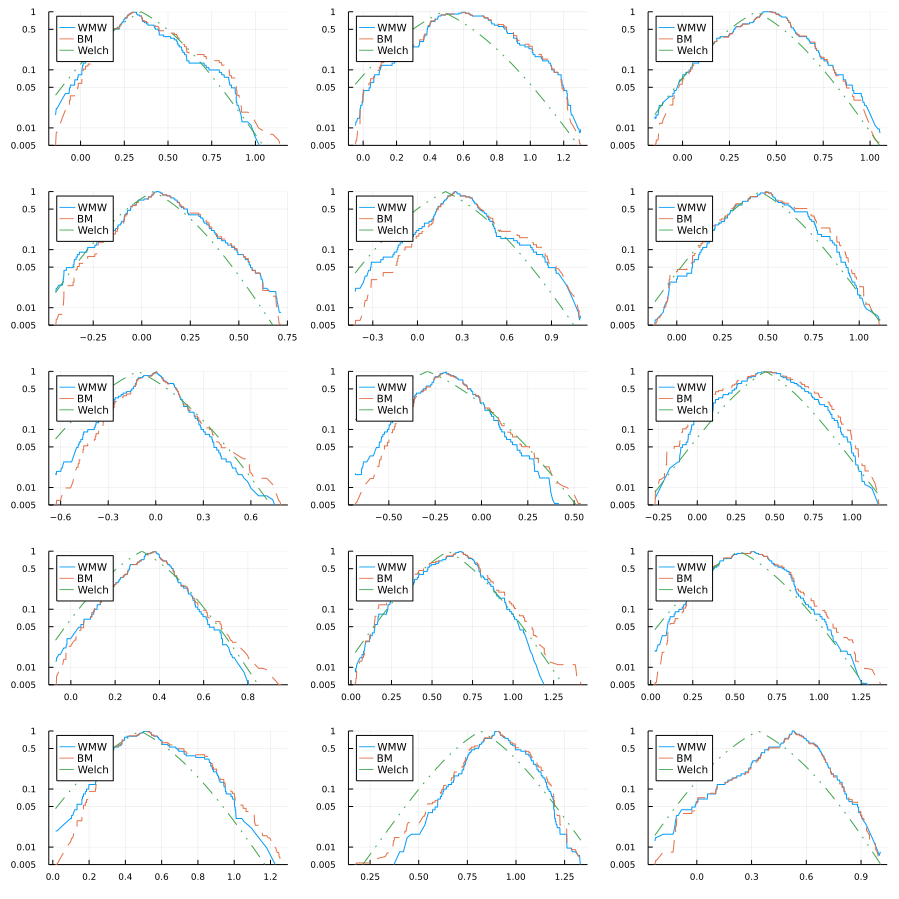

In [15]:
iterplot_pvals(Uniform(0, 2), Exponential(std(Uniform(0, 2))), 10, 20; seed=4649373)

(distx, m) = (Uniform{Float64}(a=0.0, b=2.0), 15)
(disty, n) = (Exponential{Float64}(θ=0.5773502691896257), 15)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.42264973081037427
median(distx) - median(disty) = 0.5998112887156855
tieshift(distx, disty) = 0.46294318113014316


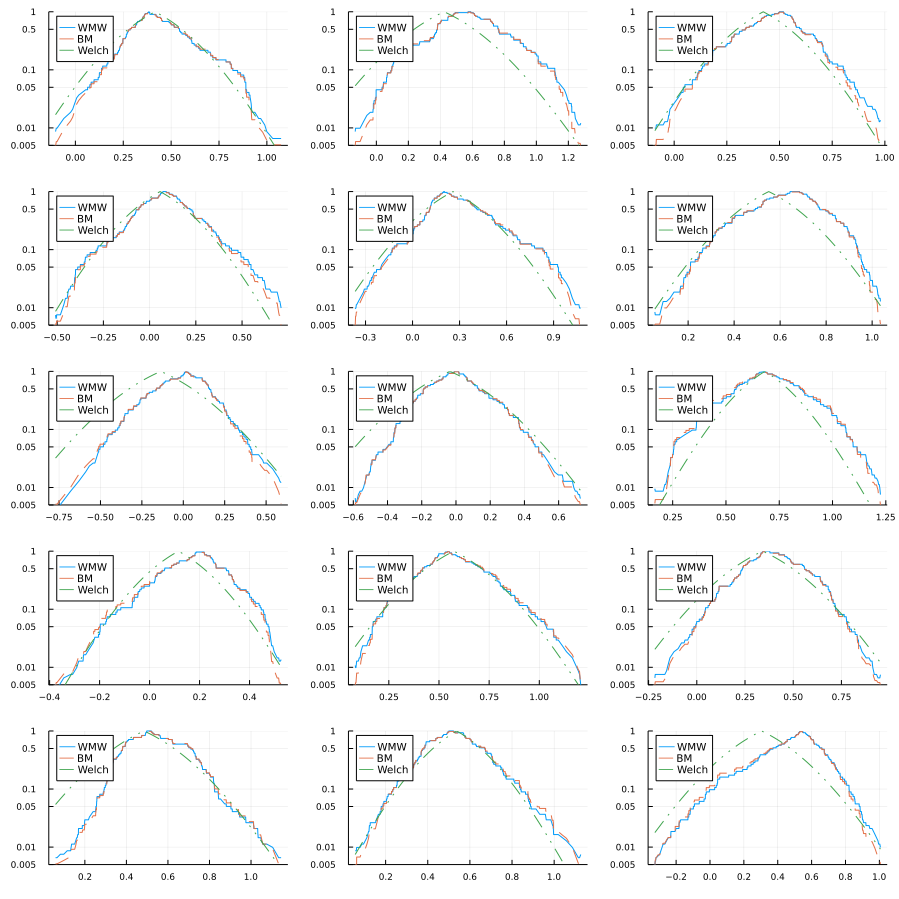

In [16]:
iterplot_pvals(Uniform(0, 2), Exponential(std(Uniform(0, 2))), 15, 15; seed=4649373)

(distx, m) = (Uniform{Float64}(a=0.0, b=2.0), 20)
(disty, n) = (Exponential{Float64}(θ=0.5773502691896257), 10)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.42264973081037427
median(distx) - median(disty) = 0.5998112887156855
tieshift(distx, disty) = 0.46294318113014316


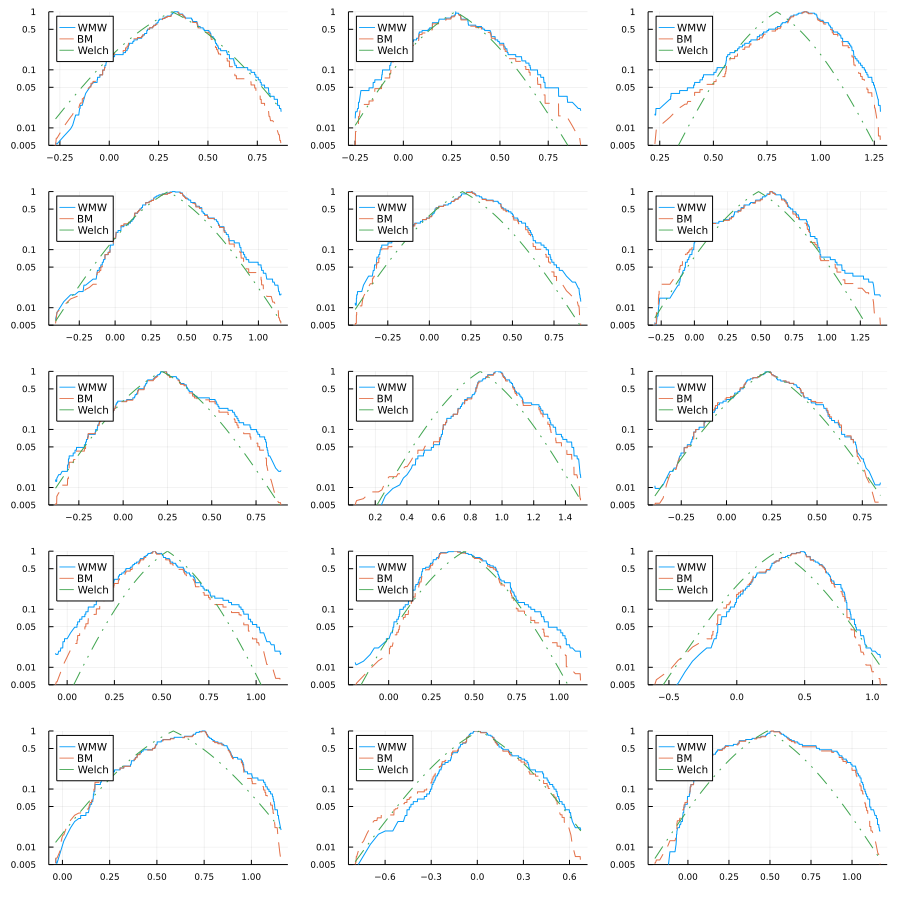

In [17]:
iterplot_pvals(Uniform(0, 2), Exponential(std(Uniform(0, 2))), 20, 10; seed=4649373)

(distx, m) = (Uniform{Float64}(a=0.0, b=2.0), 100)
(disty, n) = (Exponential{Float64}(θ=0.5773502691896257), 100)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.42264973081037427
median(distx) - median(disty) = 0.5998112887156855
tieshift(distx, disty) = 0.46294318113014316


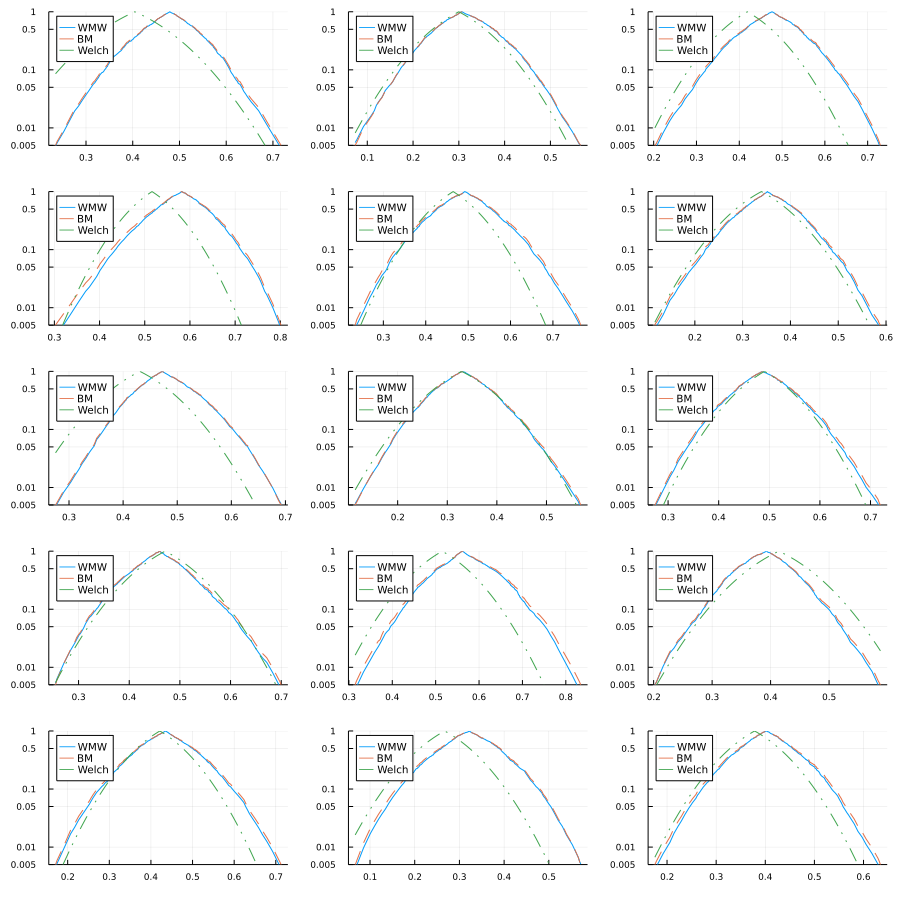

In [18]:
iterplot_pvals(Uniform(0, 2), Exponential(std(Uniform(0, 2))), 100, 100; seed=4649373)

(distx, m) = (Gamma{Float64}(α=6.0, θ=1.0), 10)
(disty, n) = (Gamma{Float64}(α=1.0, θ=6.0), 20)
std(distx) / std(disty) = 0.40824829046386296
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 1.5112781053524005
tieshift(distx, disty) = 1.3920348219223486


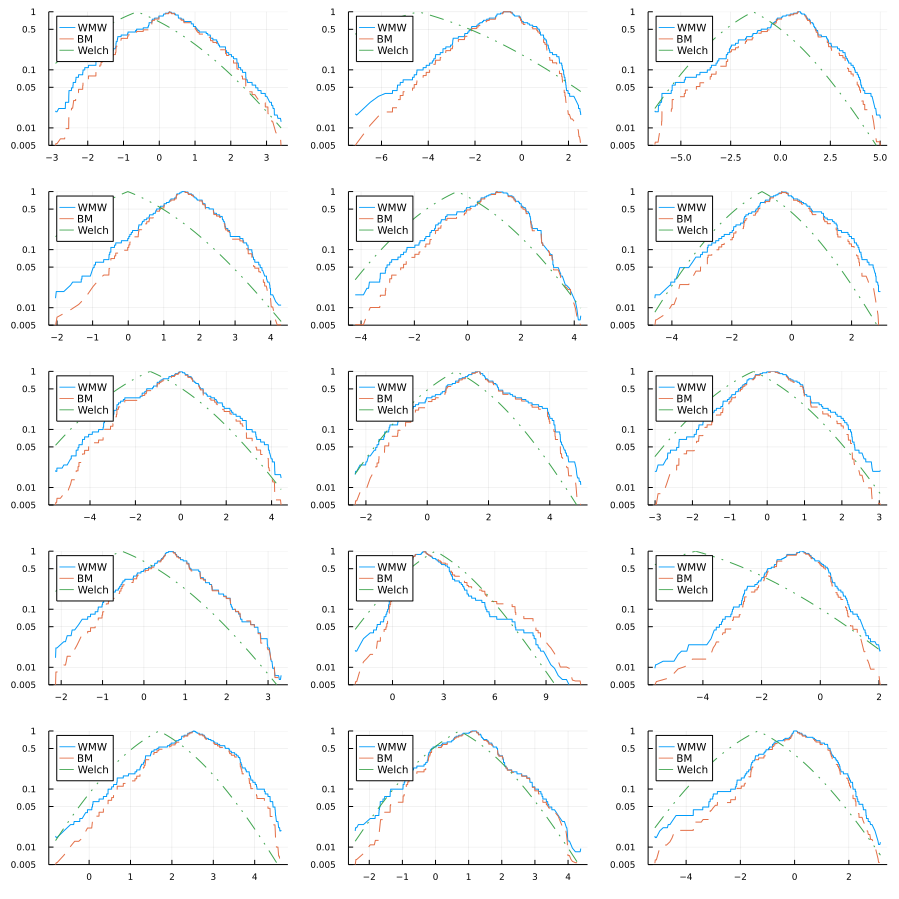

In [19]:
iterplot_pvals(Gamma(6, 1), Gamma(1, 6), 10, 20; seed=4649373)

(distx, m) = (Gamma{Float64}(α=6.0, θ=1.0), 15)
(disty, n) = (Gamma{Float64}(α=1.0, θ=6.0), 15)
std(distx) / std(disty) = 0.40824829046386296
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 1.5112781053524005
tieshift(distx, disty) = 1.3920348219223486


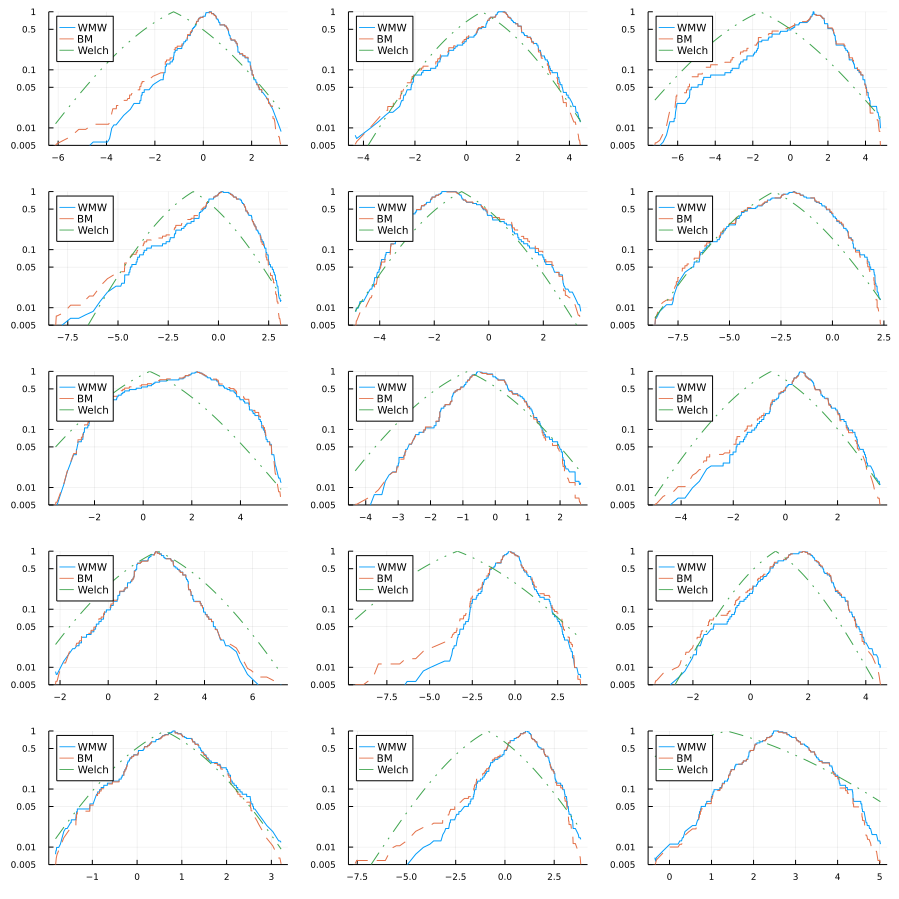

In [20]:
iterplot_pvals(Gamma(6, 1), Gamma(1, 6), 15, 15; seed=4649373)

(distx, m) = (Gamma{Float64}(α=6.0, θ=1.0), 20)
(disty, n) = (Gamma{Float64}(α=1.0, θ=6.0), 10)
std(distx) / std(disty) = 0.40824829046386296
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 1.5112781053524005
tieshift(distx, disty) = 1.3920348219223486


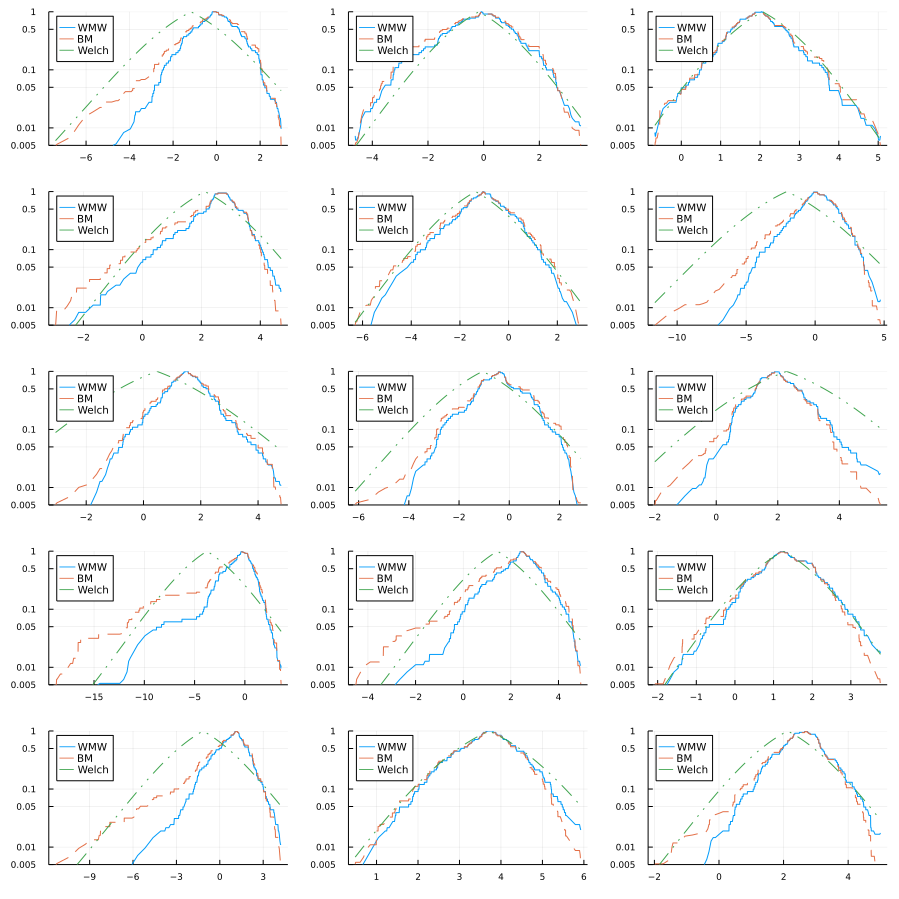

In [21]:
iterplot_pvals(Gamma(6, 1), Gamma(1, 6), 20, 10; seed=4649373)

(distx, m) = (Gamma{Float64}(α=6.0, θ=1.0), 100)
(disty, n) = (Gamma{Float64}(α=1.0, θ=6.0), 100)
std(distx) / std(disty) = 0.40824829046386296
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 1.5112781053524005
tieshift(distx, disty) = 1.3920348219223486


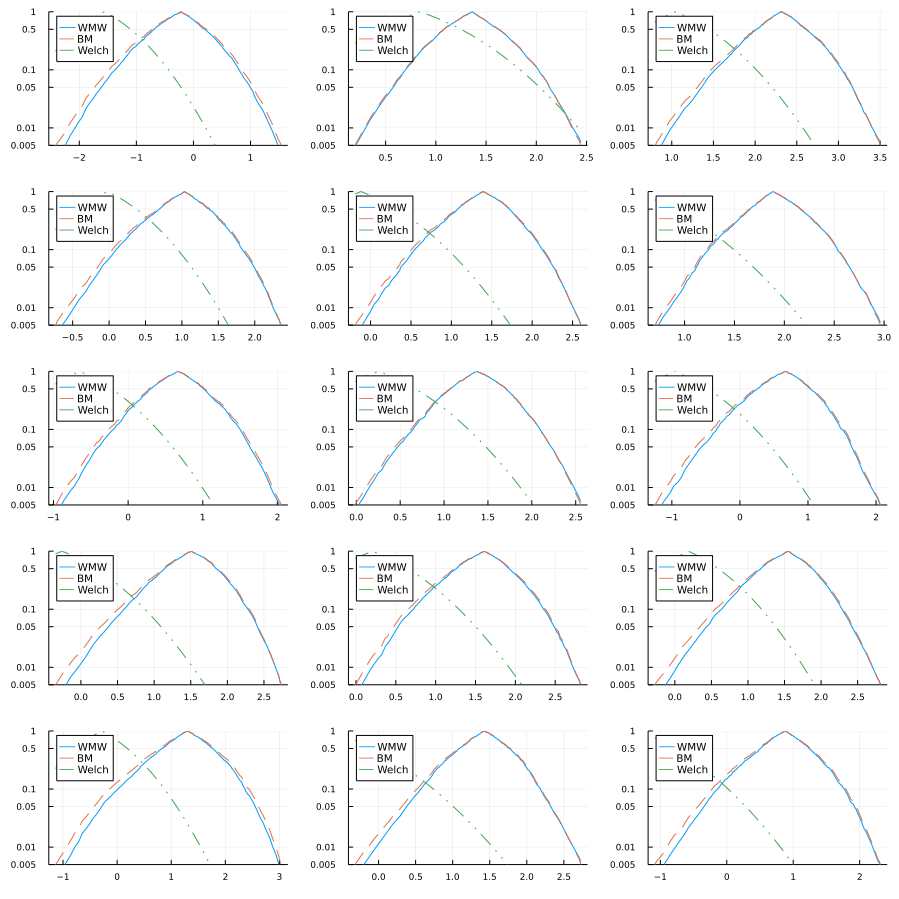

In [22]:
iterplot_pvals(Gamma(6, 1), Gamma(1, 6), 100, 100; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 20)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 7.873419302111289e-12


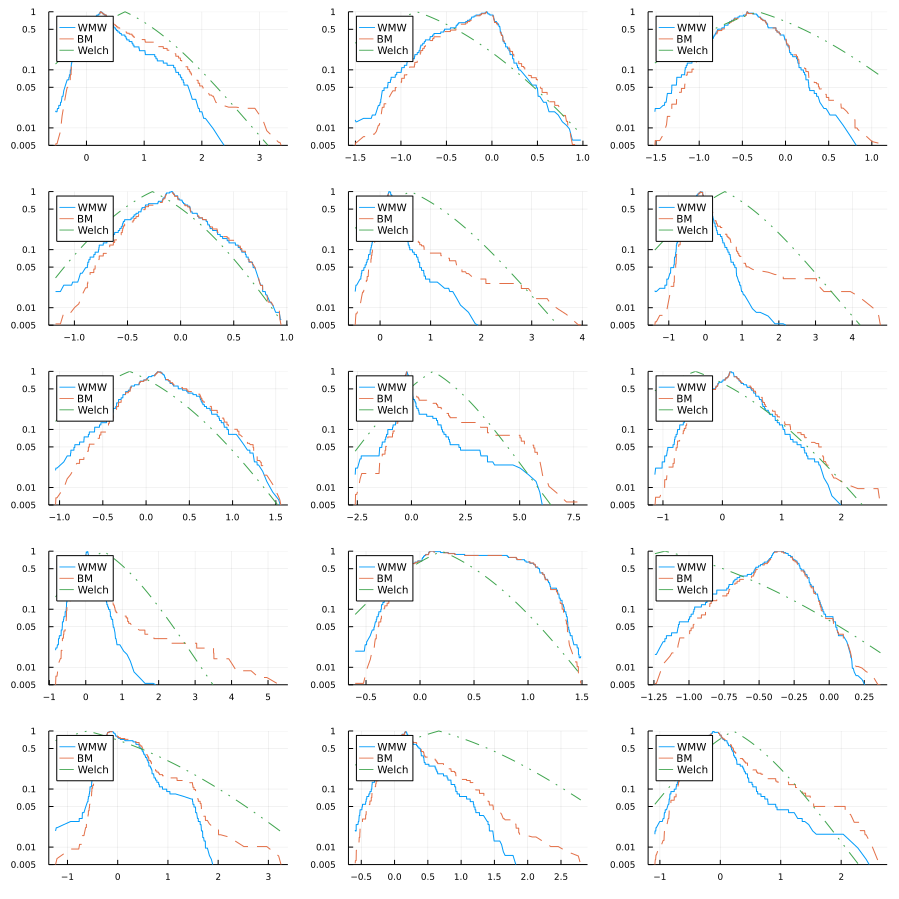

In [23]:
iterplot_pvals(LogNormal(), LogNormal(), 10, 20; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 15)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 7.873419302111289e-12


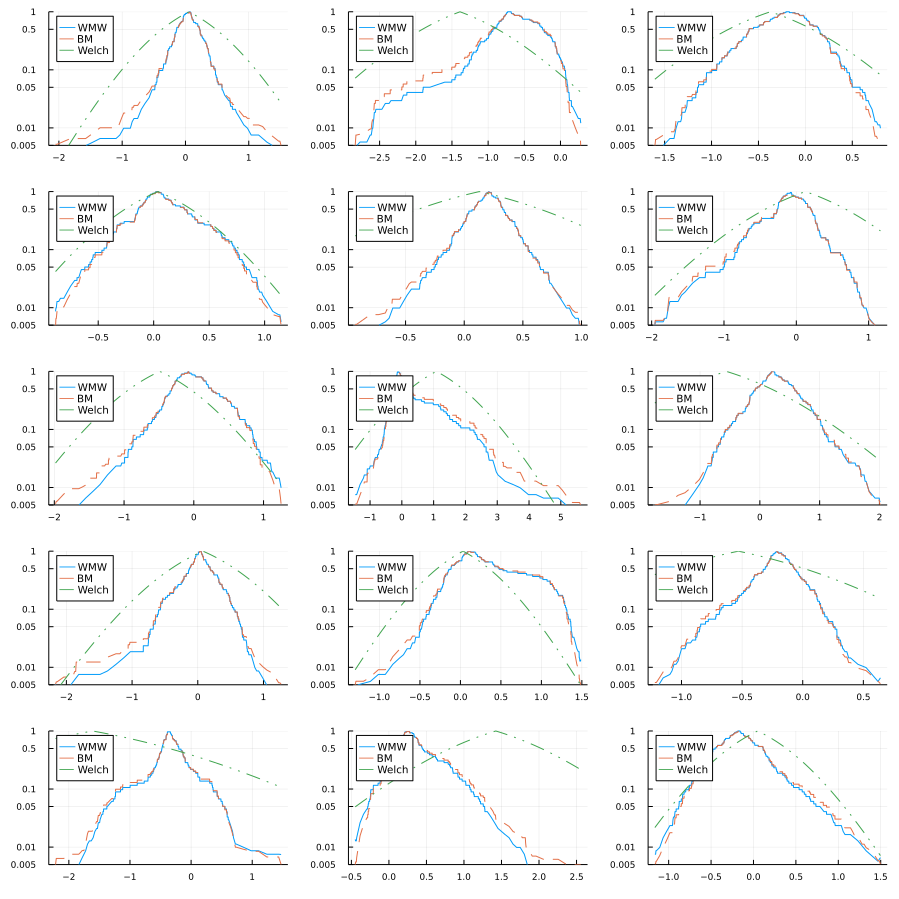

In [24]:
iterplot_pvals(LogNormal(), LogNormal(), 15, 15; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 7.873419302111289e-12


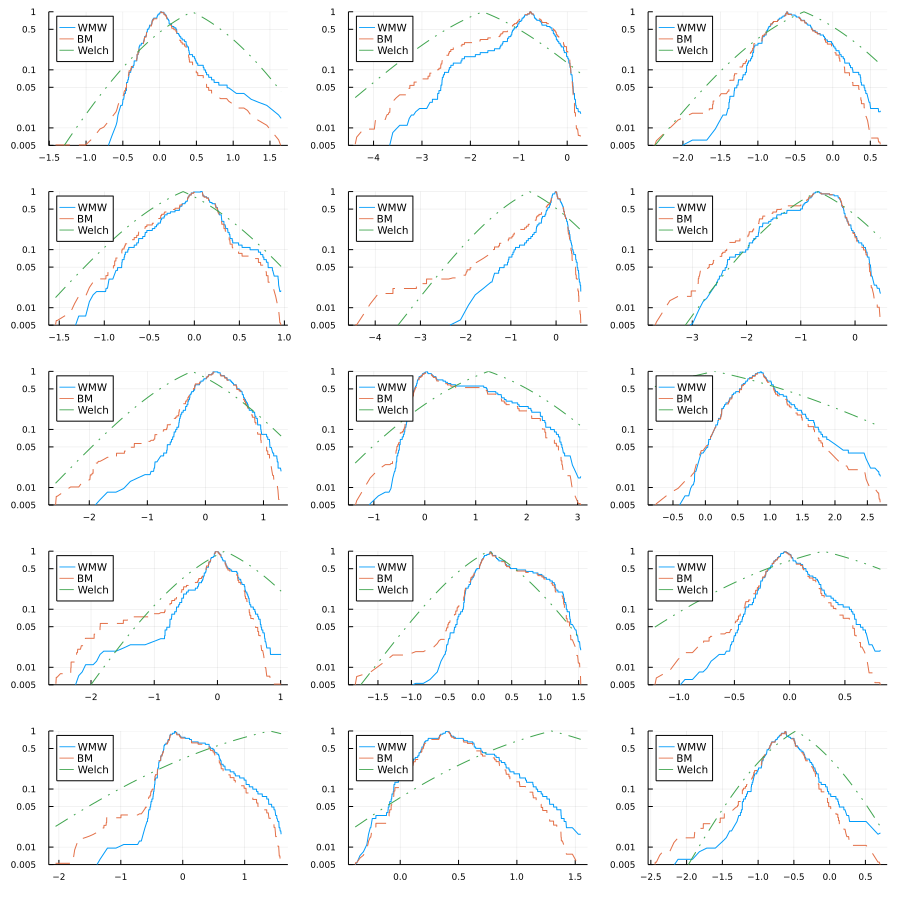

In [25]:
iterplot_pvals(LogNormal(), LogNormal(), 20, 10; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 100)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.0
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 7.873419302111289e-12


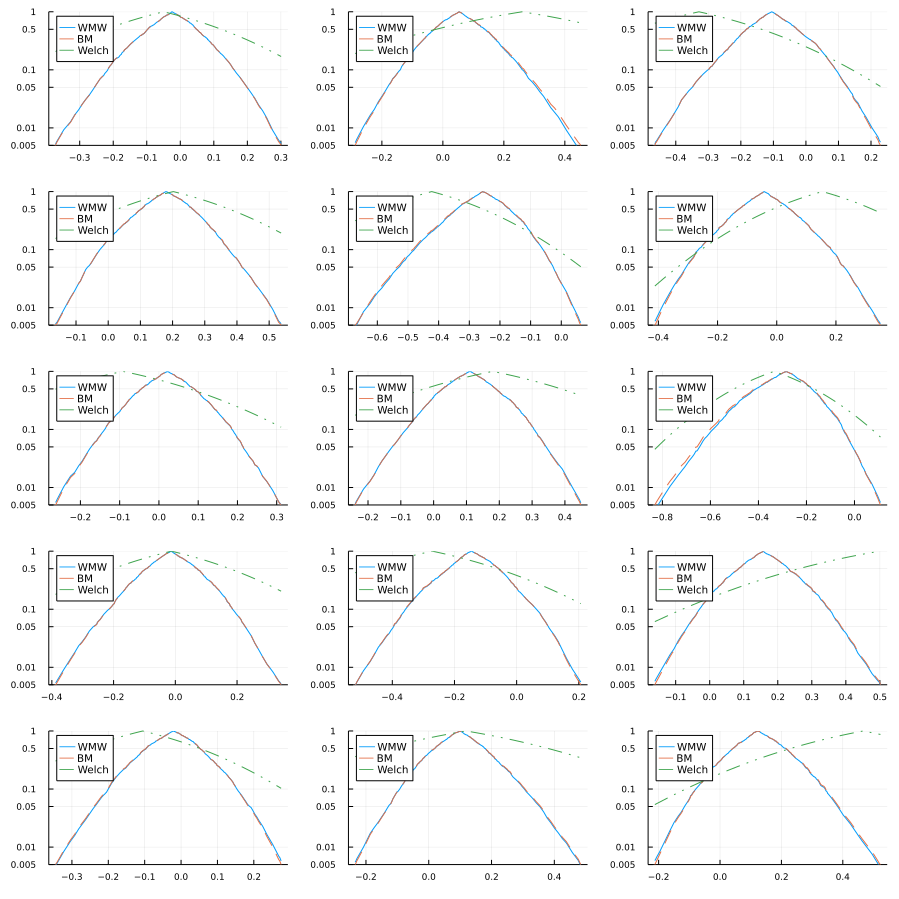

In [26]:
iterplot_pvals(LogNormal(), LogNormal(), 100, 100; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 20)
std(distx) / std(disty) = 0.36787944117144233
mean(distx) - mean(disty) = -2.8329677996379363
median(distx) - median(disty) = -1.718281828459045
tieshift(distx, disty) = -1.4744426128871542


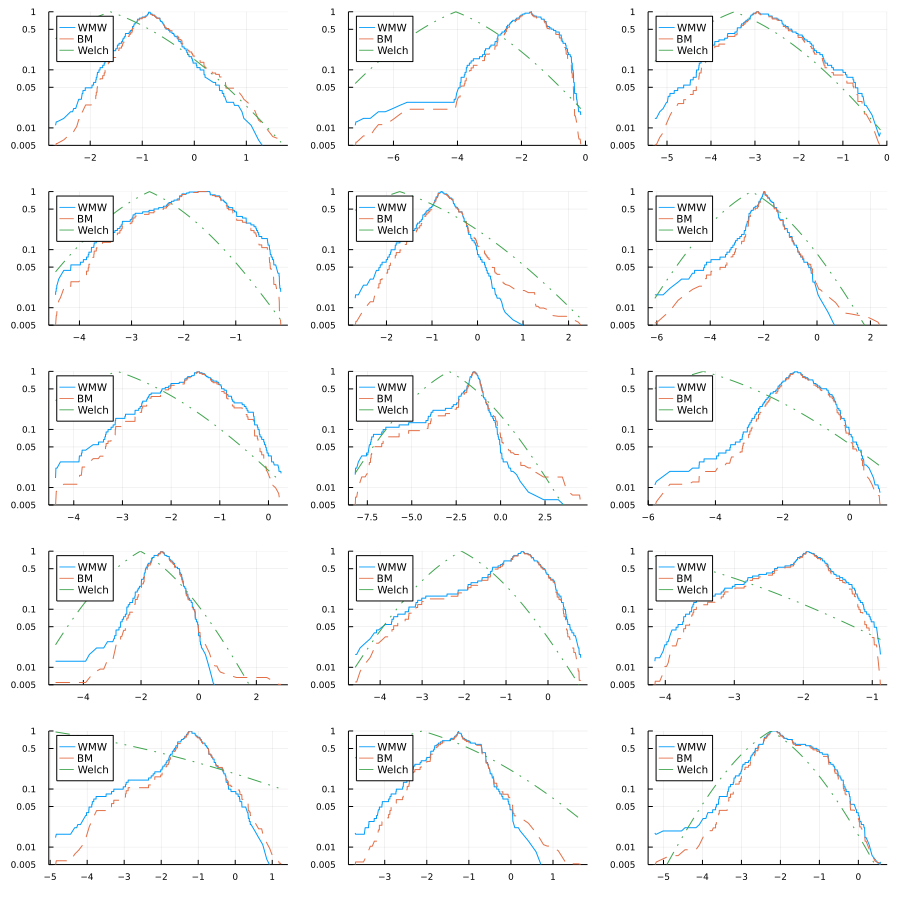

In [27]:
iterplot_pvals(LogNormal(), LogNormal(1), 10, 20; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 15)
std(distx) / std(disty) = 0.36787944117144233
mean(distx) - mean(disty) = -2.8329677996379363
median(distx) - median(disty) = -1.718281828459045
tieshift(distx, disty) = -1.4744426128871542


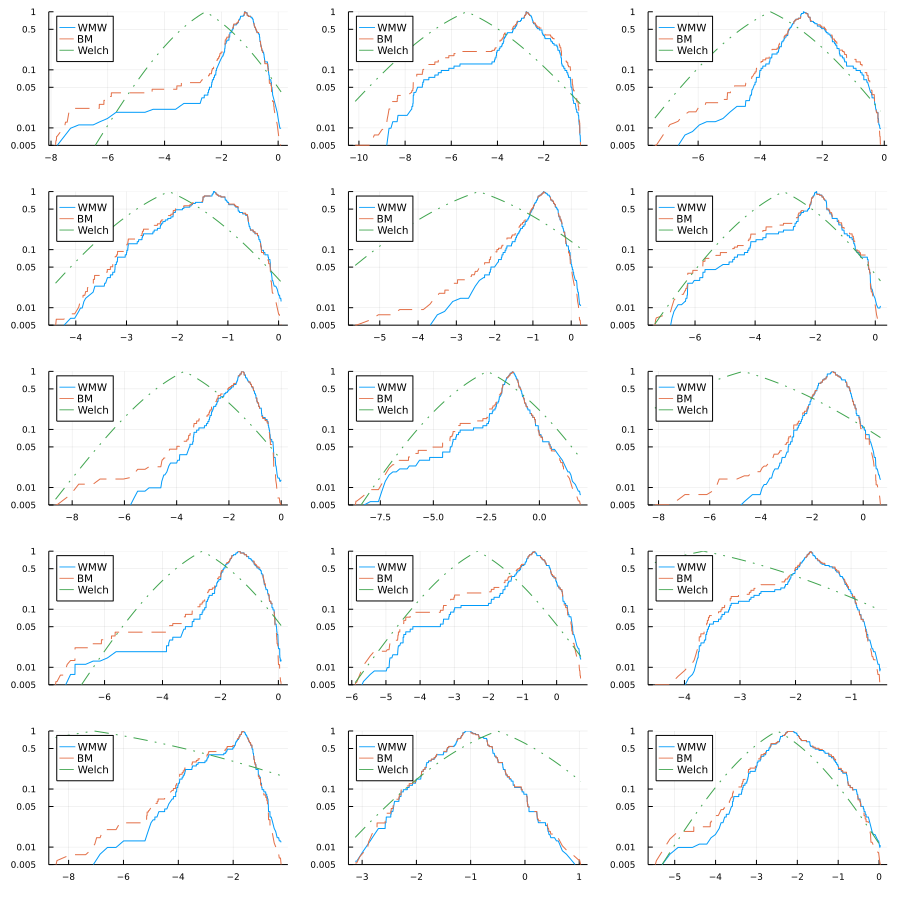

In [28]:
iterplot_pvals(LogNormal(), LogNormal(1), 15, 15; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 10)
std(distx) / std(disty) = 0.36787944117144233
mean(distx) - mean(disty) = -2.8329677996379363
median(distx) - median(disty) = -1.718281828459045
tieshift(distx, disty) = -1.4744426128871542


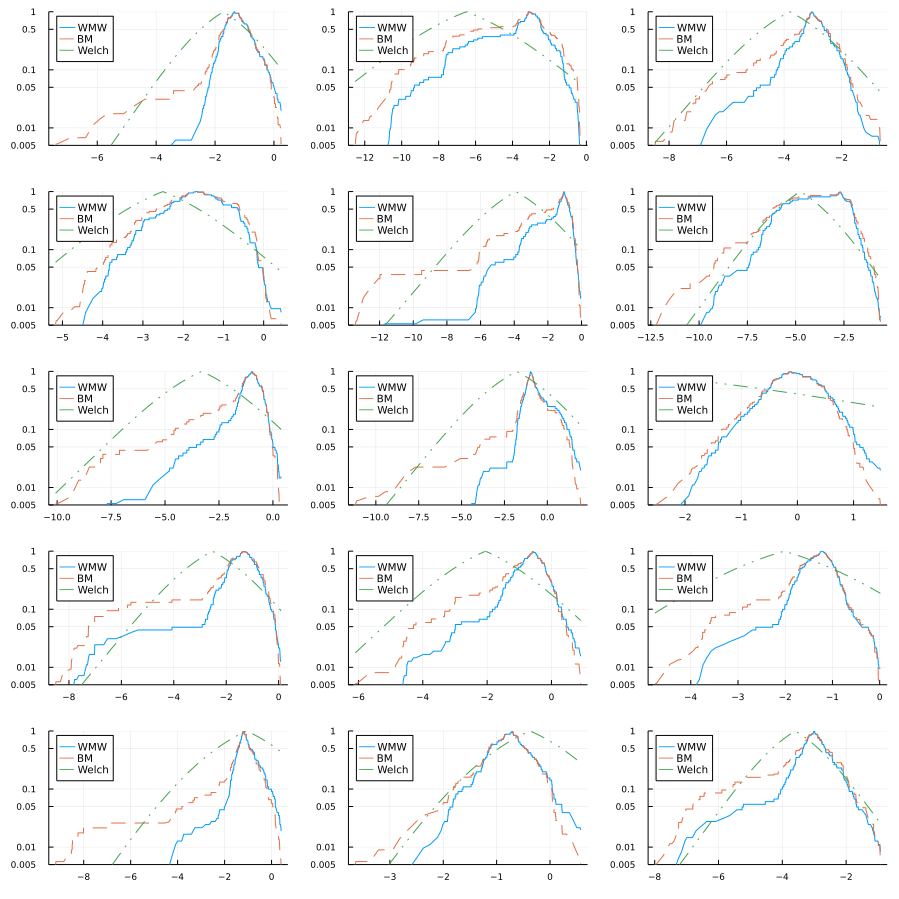

In [29]:
iterplot_pvals(LogNormal(), LogNormal(1), 20, 10; seed=4649373)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 100)
std(distx) / std(disty) = 0.36787944117144233
mean(distx) - mean(disty) = -2.8329677996379363
median(distx) - median(disty) = -1.718281828459045
tieshift(distx, disty) = -1.4744426128871542


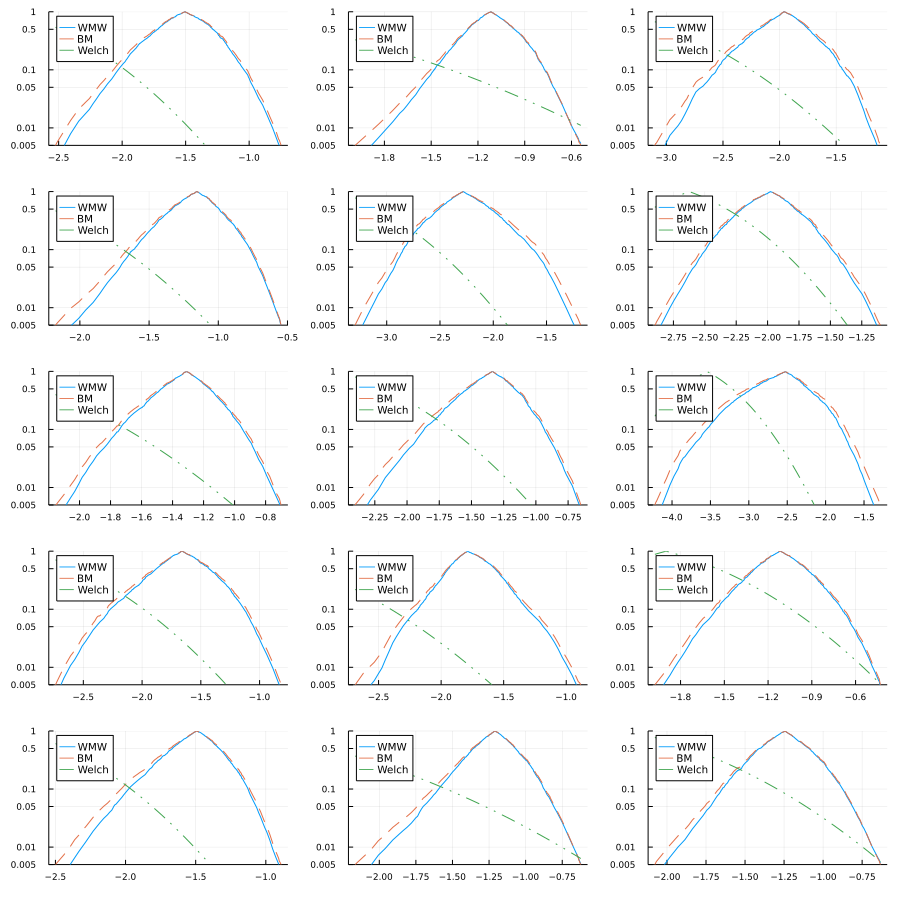

In [30]:
iterplot_pvals(LogNormal(), LogNormal(1), 100, 100; seed=4649373)

(distx, m) = (Gamma{Float64}(α=1.0, θ=2.1611974158950877), 10)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 20)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.5124761451949595
median(distx) - median(disty) = 0.49802789546111903
tieshift(distx, disty) = 0.3244857334247666


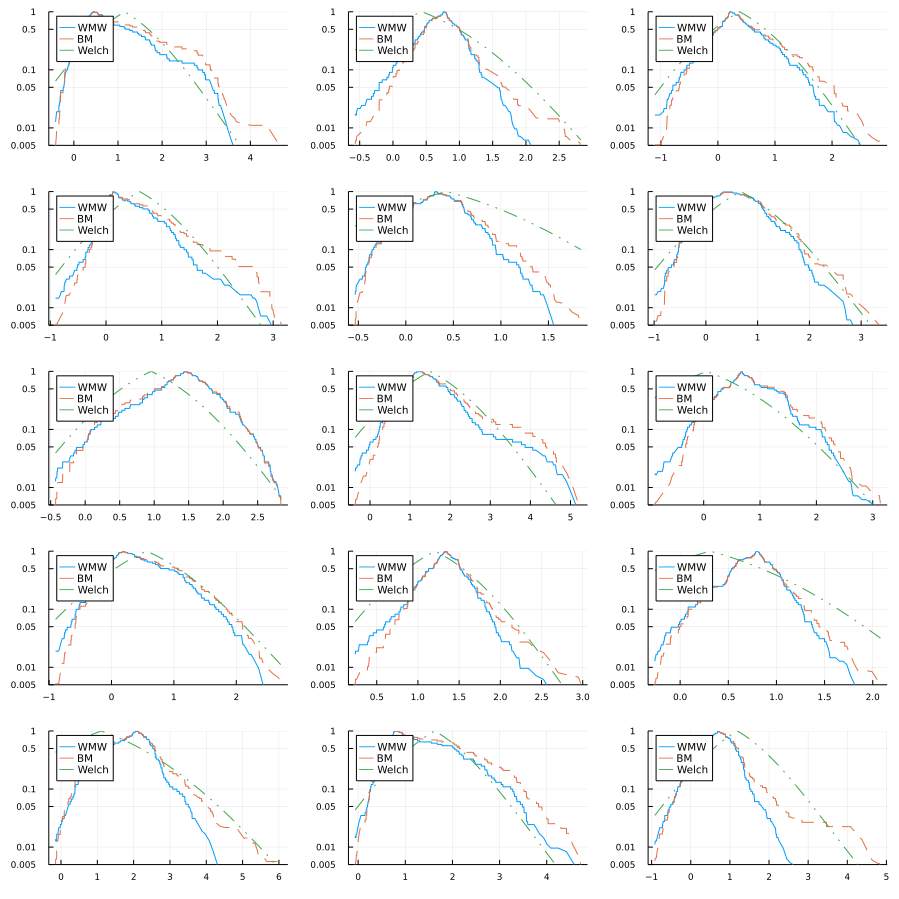

In [31]:
iterplot_pvals(Gamma(1, std(LogNormal())), LogNormal(), 10, 20; seed=4649373)

(distx, m) = (Gamma{Float64}(α=1.0, θ=2.1611974158950877), 15)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 15)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.5124761451949595
median(distx) - median(disty) = 0.49802789546111903
tieshift(distx, disty) = 0.3244857334247666


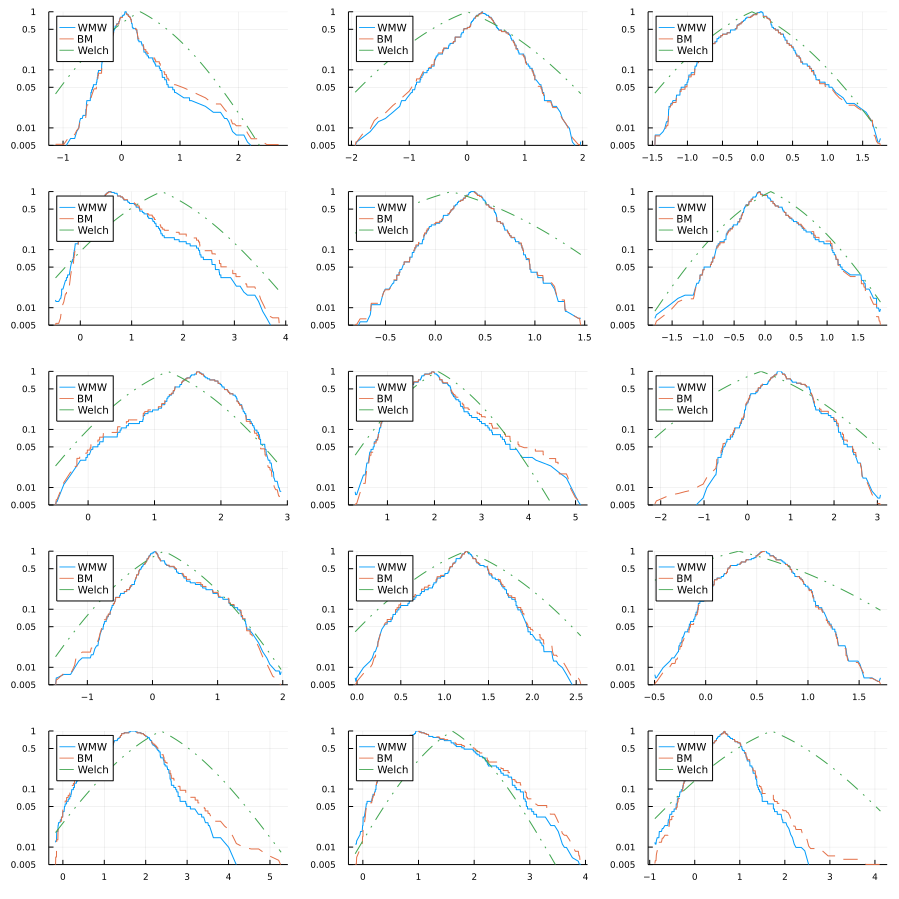

In [32]:
iterplot_pvals(Gamma(1, std(LogNormal())), LogNormal(), 15, 15; seed=4649373)

(distx, m) = (Gamma{Float64}(α=1.0, θ=2.1611974158950877), 20)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.5124761451949595
median(distx) - median(disty) = 0.49802789546111903
tieshift(distx, disty) = 0.3244857334247666


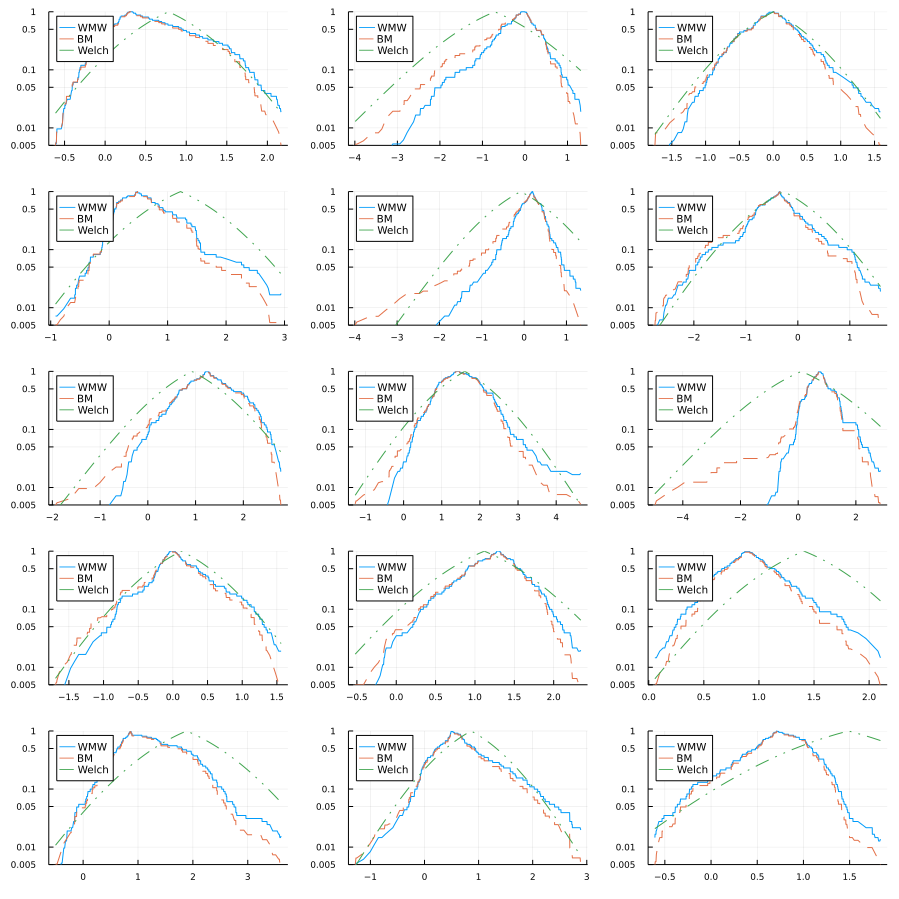

In [33]:
iterplot_pvals(Gamma(1, std(LogNormal())), LogNormal(), 20, 10; seed=4649373)

(distx, m) = (Gamma{Float64}(α=1.0, θ=2.1611974158950877), 100)
(disty, n) = (LogNormal{Float64}(μ=0.0, σ=1.0), 100)
std(distx) / std(disty) = 1.0
mean(distx) - mean(disty) = 0.5124761451949595
median(distx) - median(disty) = 0.49802789546111903
tieshift(distx, disty) = 0.3244857334247666


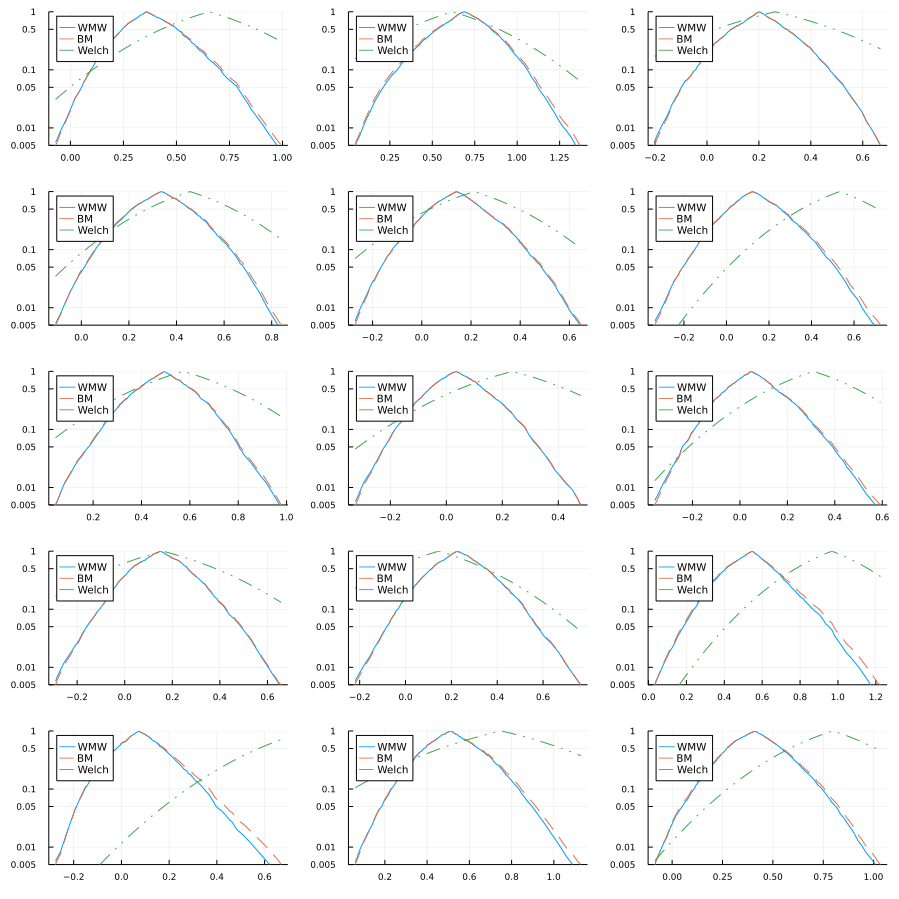

In [34]:
iterplot_pvals(Gamma(1, std(LogNormal())), LogNormal(), 100, 100; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=1.0), 20)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


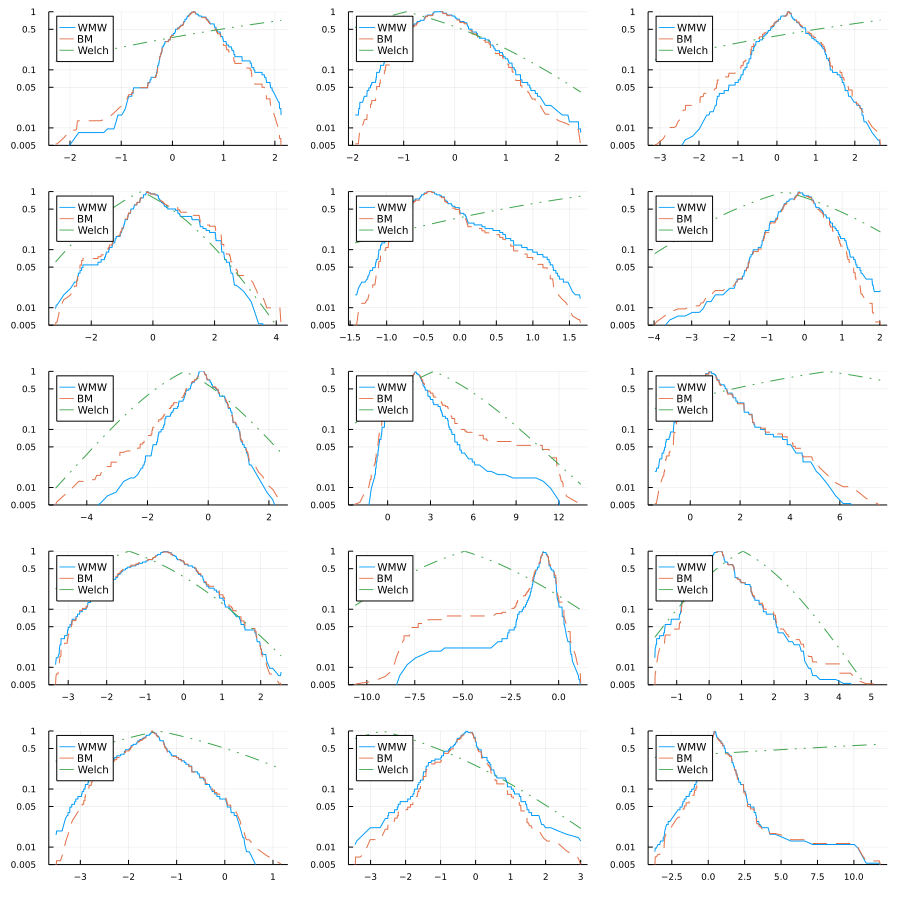

In [35]:
iterplot_pvals(Cauchy(), Cauchy(), 10, 20; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=1.0), 15)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


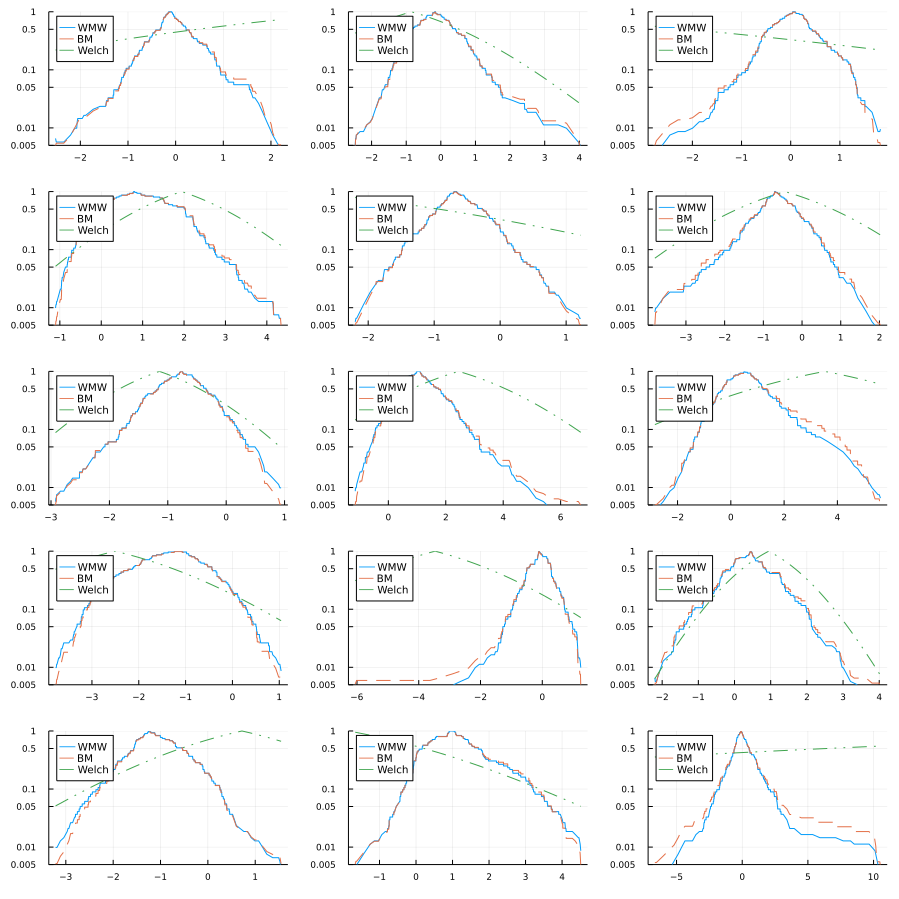

In [36]:
iterplot_pvals(Cauchy(), Cauchy(), 15, 15; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=1.0), 10)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


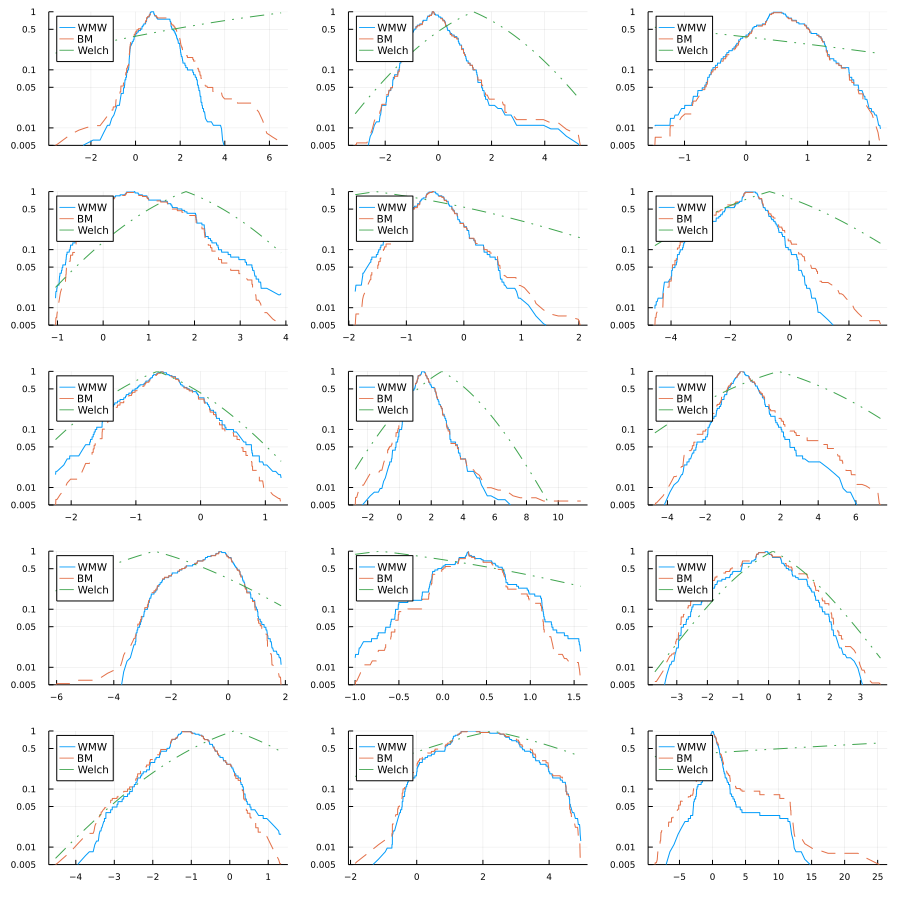

In [37]:
iterplot_pvals(Cauchy(), Cauchy(), 20, 10; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=1.0), 100)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


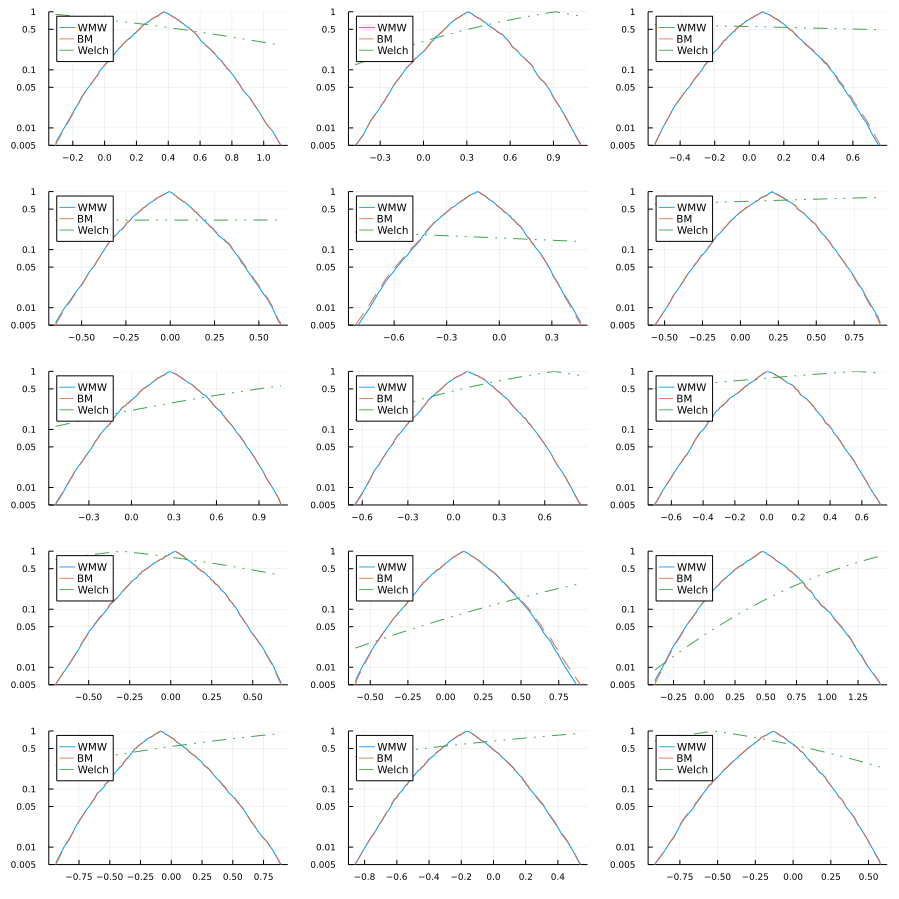

In [38]:
iterplot_pvals(Cauchy(), Cauchy(), 100, 100; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=2.0), 20)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


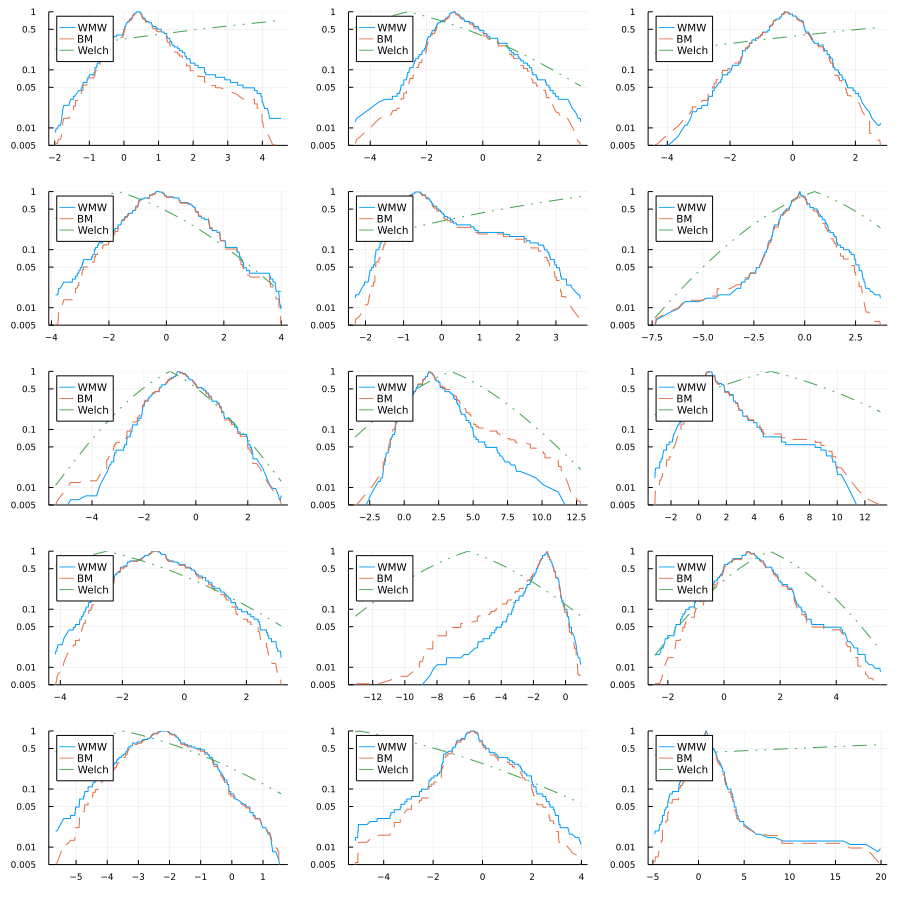

In [39]:
iterplot_pvals(Cauchy(), Cauchy(0, 2), 10, 20; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 15)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=2.0), 15)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


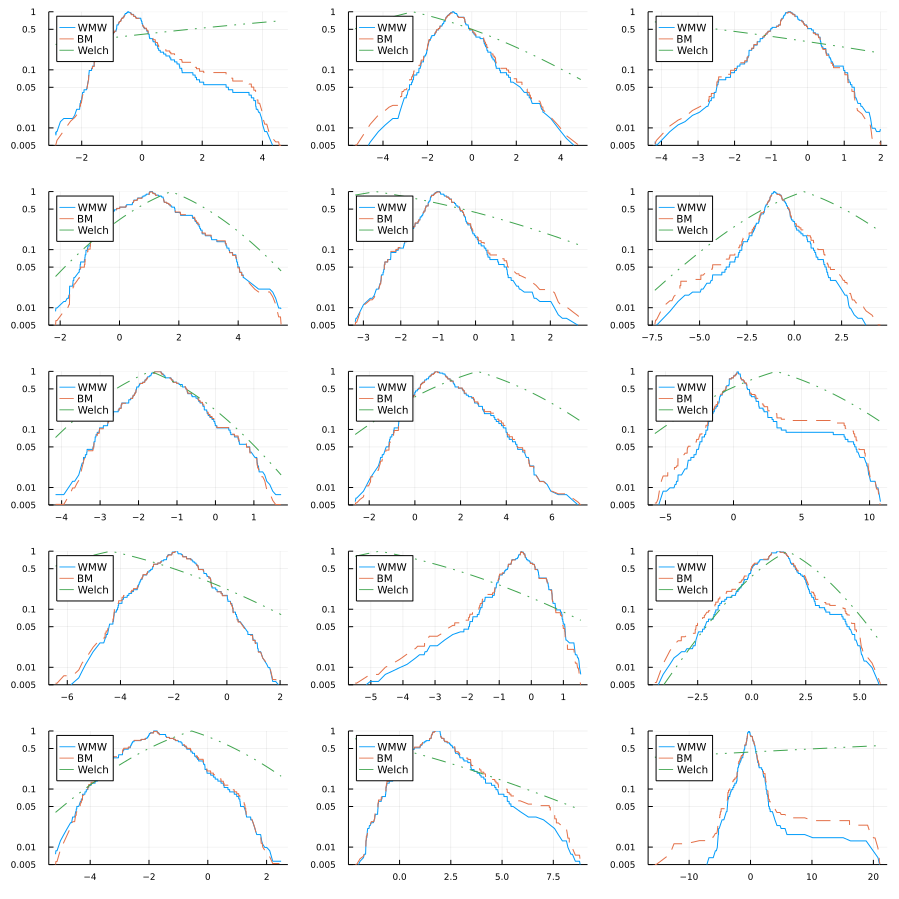

In [40]:
iterplot_pvals(Cauchy(), Cauchy(0, 2), 15, 15; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 20)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=2.0), 10)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


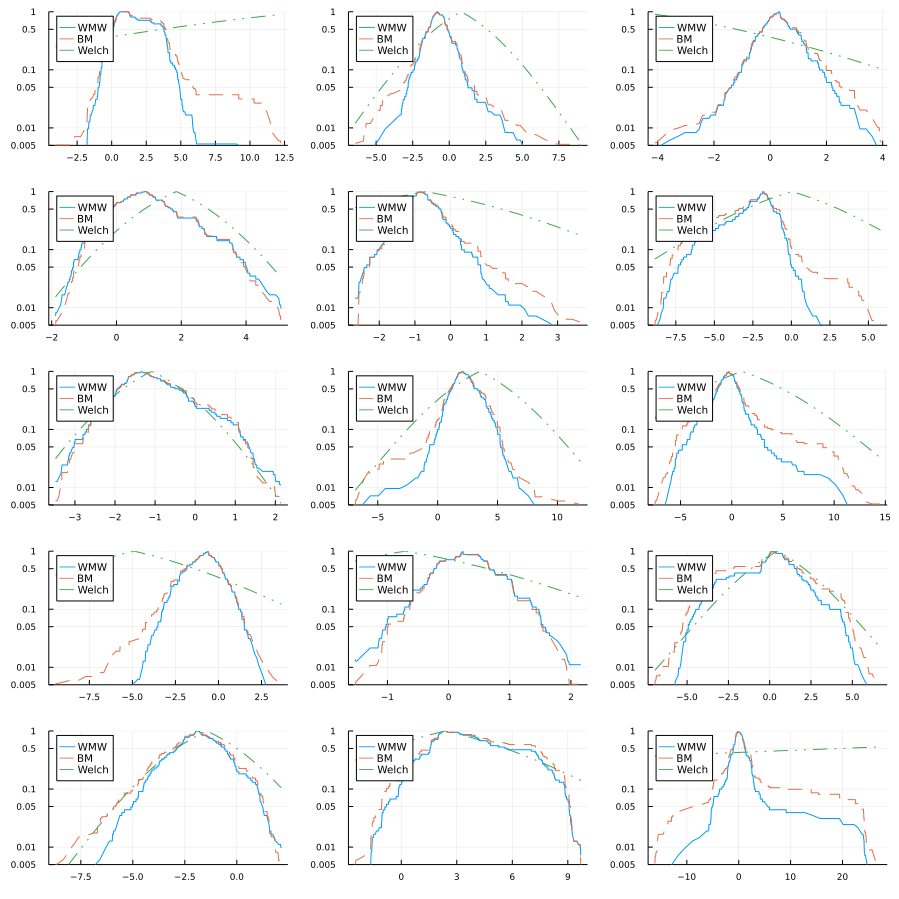

In [41]:
iterplot_pvals(Cauchy(), Cauchy(0, 2), 20, 10; seed=4649373)

(distx, m) = (Cauchy{Float64}(μ=0.0, σ=1.0), 100)
(disty, n) = (Cauchy{Float64}(μ=0.0, σ=2.0), 100)
std(distx) / std(disty) = NaN
mean(distx) - mean(disty) = NaN
median(distx) - median(disty) = 0.0
tieshift(distx, disty) = 0.0


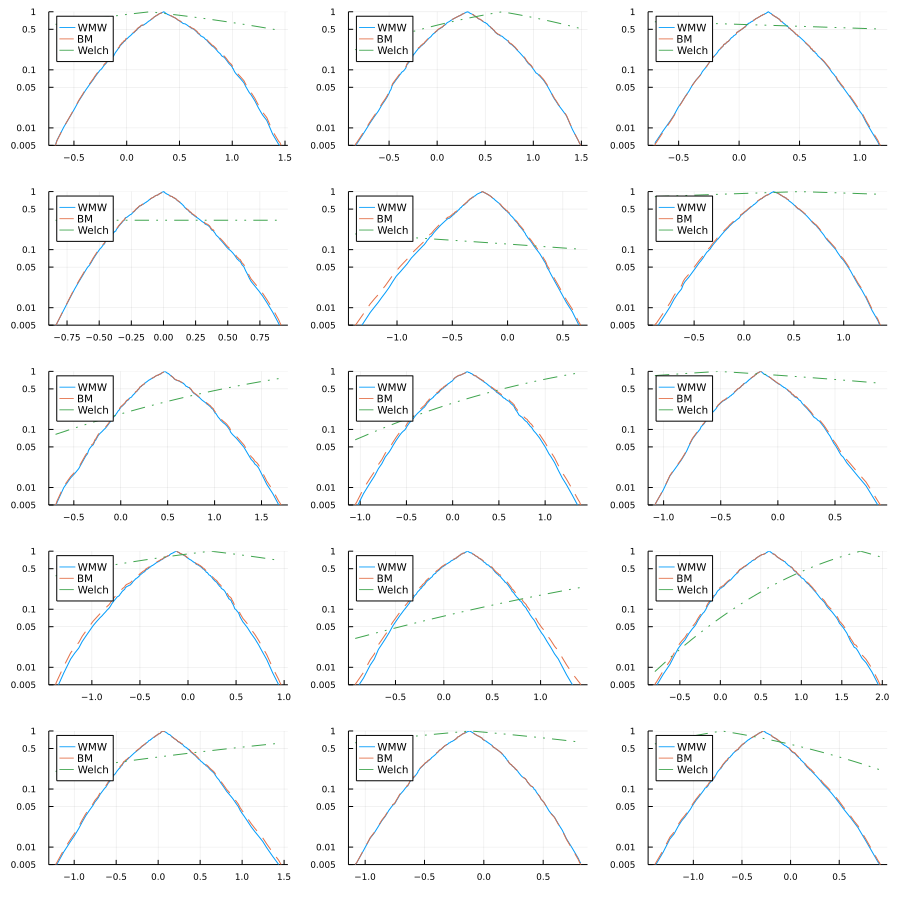

In [42]:
iterplot_pvals(Cauchy(), Cauchy(0, 2), 100, 100; seed=4649373)